In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# include CalTech

data_dir = 'data/CalTech256'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes, class_names, sep='\n')

{'train': 1946, 'val': 602}
['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101']


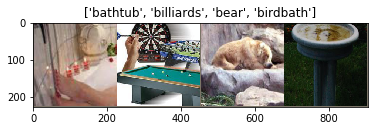

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# TODO
# convert func to CalTech dataset for avoid IndexError

def top_k_error(model, k = 1):
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        model.eval()

        output = model(inputs)

        _, indices = torch.sort(out, descending=True)
        percentage = nn.functional.softmax(out, dim=1)[0] * 100
        print([(labels[idx], percentage[idx].item()) for idx in indices[0][:2]])

In [4]:
# TODO
# calculate top-1 and top-5
# fix percentage of loss

def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_acc = 0.0
    
    epoch_loss_history = []
    epoch_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in dataloaders.keys():
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        pass
                    pass

                # statistics
                    # here's problem about percentage of loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pass
            
            if phase == 'train':
                scheduler.step()
                pass

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                epoch_loss_history.append(epoch_loss)
                epoch_acc_history.append(epoch_acc)
                pass

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                pass
            pass

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    del model
    return epoch_loss_history, epoch_acc_history, \
           best_acc.item(), (time_elapsed / 3600)

In [5]:
losses = {}
accuracies = {}
best_accuracy = {}
time_expired = {}

In [4]:
def view_accuracy_all():
    for experiment_id in accuracies.keys():
        plt.plot(accuracies[experiment_id], label=experiment_id)
    plt.legend()
    plt.title('Validation Accuracy');
    
    
def view_loss_all():
    for experiment_id in losses.keys():
        plt.plot(losses[experiment_id], label=experiment_id)
    plt.legend()
    plt.title('Validation Loss');

In [6]:
def view_validation_accuracy(name):
    plt.plot(accuracies[name], label='accuracy')
    plt.legend()
    plt.title('Validation Accuracy');
    
    
def view_validation_loss(name):
    plt.plot(losses[name], label='loss')
    plt.legend()
    plt.title('Validation Loss');

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
losses['resnet18'], accuracies['resnet18'], \
best_accuracy['resnet18'], time_expired['resnet18'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.7174 Acc: 0.5134
val Loss: 0.5099 Acc: 0.8605

Epoch 2/30
----------
train Loss: 1.1801 Acc: 0.6593
val Loss: 0.4989 Acc: 0.8754

Epoch 3/30
----------
train Loss: 1.1435 Acc: 0.6737
val Loss: 0.4967 Acc: 0.8721

Epoch 4/30
----------
train Loss: 1.0741 Acc: 0.6994
val Loss: 0.5809 Acc: 0.8671

Epoch 5/30
----------
train Loss: 0.9101 Acc: 0.7503
val Loss: 0.5743 Acc: 0.8588

Epoch 6/30
----------
train Loss: 0.9249 Acc: 0.7467
val Loss: 0.5896 Acc: 0.8638

Epoch 7/30
----------
train Loss: 0.9252 Acc: 0.7451
val Loss: 0.4315 Acc: 0.8854

Epoch 8/30
----------
train Loss: 0.6566 Acc: 0.8150
val Loss: 0.3379 Acc: 0.9136

Epoch 9/30
----------
train Loss: 0.5810 Acc: 0.8350
val Loss: 0.3070 Acc: 0.9286

Epoch 10/30
----------
train Loss: 0.5209 Acc: 0.8458
val Loss: 0.2962 Acc: 0.9286

Epoch 11/30
----------
train Loss: 0.5363 Acc: 0.8499
val Loss: 0.2845 Acc: 0.9336

Epoch 12/30
----------
train Loss: 0.5167 Acc: 0.8551
val Loss: 0.2694 Acc: 0.9336

E

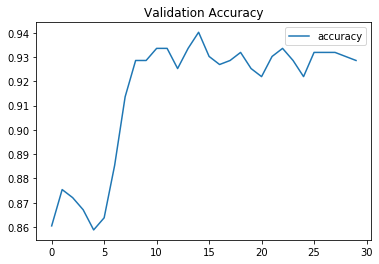

In [14]:
view_validation_accuracy('resnet18')

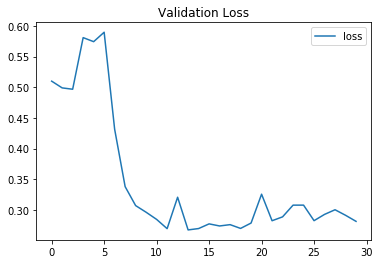

In [15]:
view_validation_loss('resnet18')

In [16]:
print(best_accuracy['resnet18'])
print(time_expired['resnet18'])

0.9401993355481728
1737.929129600525


In [7]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
losses['resnet34'], accuracies['resnet34'], \
best_accuracy['resnet34'], time_expired['resnet34'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.5774 Acc: 0.5498
val Loss: 0.5603 Acc: 0.8439

Epoch 2/30
----------
train Loss: 1.2081 Acc: 0.6495
val Loss: 0.5379 Acc: 0.8588

Epoch 3/30
----------
train Loss: 1.0809 Acc: 0.6855
val Loss: 0.4162 Acc: 0.8920

Epoch 4/30
----------
train Loss: 0.9847 Acc: 0.7276
val Loss: 0.4103 Acc: 0.8987

Epoch 5/30
----------
train Loss: 0.9314 Acc: 0.7456
val Loss: 0.4355 Acc: 0.8937

Epoch 6/30
----------
train Loss: 0.9058 Acc: 0.7425
val Loss: 0.4271 Acc: 0.8887

Epoch 7/30
----------
train Loss: 0.8163 Acc: 0.7713
val Loss: 0.5452 Acc: 0.8721

Epoch 8/30
----------
train Loss: 0.6643 Acc: 0.8165
val Loss: 0.3753 Acc: 0.9186

Epoch 9/30
----------
train Loss: 0.5588 Acc: 0.8546
val Loss: 0.3188 Acc: 0.9169

Epoch 10/30
----------
train Loss: 0.5938 Acc: 0.8299
val Loss: 0.3513 Acc: 0.9136

Epoch 11/30
----------
train Loss: 0.5136 Acc: 0.8628
val Loss: 0.3076 Acc: 0.9385

Epoch 12/30
----------
train Loss: 0.4803 Acc: 0.8684
val Loss: 0.2954 Acc: 0.9319

E

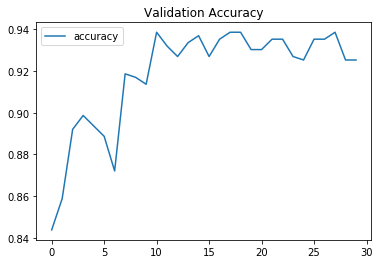

In [9]:
view_validation_accuracy('resnet34')

In [10]:
print(best_accuracy['resnet34'])
print(time_expired['resnet34'])

0.9385382059800664
0.6406627170244853


In [17]:
model_ft = models.alexnet(pretrained=True)
# model_ft.classifier[6] # - get last layer
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
losses['alexnet'], accuracies['alexnet'], \
best_accuracy['alexnet'], time_expired['alexnet'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.9290 Acc: 0.4471
val Loss: 1.6367 Acc: 0.5415

Epoch 2/30
----------
train Loss: 1.5467 Acc: 0.5488
val Loss: 1.0197 Acc: 0.7243

Epoch 3/30
----------
train Loss: 1.3577 Acc: 0.6110
val Loss: 1.1189 Acc: 0.6827

Epoch 4/30
----------
train Loss: 1.2821 Acc: 0.6305
val Loss: 0.9734 Acc: 0.7010

Epoch 5/30
----------
train Loss: 1.1764 Acc: 0.6418
val Loss: 1.0369 Acc: 0.7126

Epoch 6/30
----------
train Loss: 1.1923 Acc: 0.6511
val Loss: 1.0916 Acc: 0.6993

Epoch 7/30
----------
train Loss: 1.0663 Acc: 0.6958
val Loss: 1.0255 Acc: 0.7193

Epoch 8/30
----------
train Loss: 0.7130 Acc: 0.7909
val Loss: 0.6592 Acc: 0.8239

Epoch 9/30
----------
train Loss: 0.6085 Acc: 0.8150
val Loss: 0.5995 Acc: 0.8322

Epoch 10/30
----------
train Loss: 0.5792 Acc: 0.8227
val Loss: 0.5919 Acc: 0.8322

Epoch 11/30
----------
train Loss: 0.4835 Acc: 0.8613
val Loss: 0.6237 Acc: 0.8322

Epoch 12/30
----------
train Loss: 0.4721 Acc: 0.8525
val Loss: 0.5928 Acc: 0.8439

E

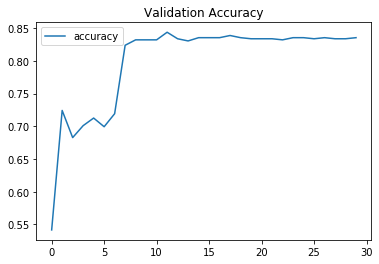

In [19]:
view_validation_accuracy('alexnet')

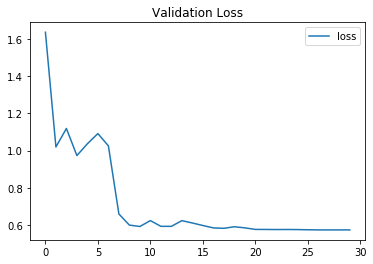

In [20]:
view_validation_loss('alexnet')

In [21]:
model_ft = models.vgg11_bn(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
losses['vgg11_bn'], accuracies['vgg11_bn'], \
best_accuracy['vgg11_bn'], time_expired['vgg11_bn'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.3304 Acc: 0.6305
val Loss: 0.5063 Acc: 0.8638

Epoch 2/30
----------
train Loss: 0.9076 Acc: 0.7390
val Loss: 0.4455 Acc: 0.8721

Epoch 3/30
----------
train Loss: 0.7745 Acc: 0.7667
val Loss: 0.3876 Acc: 0.8854

Epoch 4/30
----------
train Loss: 0.6761 Acc: 0.8032
val Loss: 0.3908 Acc: 0.8987

Epoch 5/30
----------
train Loss: 0.6246 Acc: 0.8155
val Loss: 0.3697 Acc: 0.8987

Epoch 6/30
----------
train Loss: 0.6370 Acc: 0.8155
val Loss: 0.3534 Acc: 0.8953

Epoch 7/30
----------
train Loss: 0.5524 Acc: 0.8345
val Loss: 0.3762 Acc: 0.8854

Epoch 8/30
----------
train Loss: 0.4349 Acc: 0.8736
val Loss: 0.3287 Acc: 0.9153

Epoch 9/30
----------
train Loss: 0.3550 Acc: 0.8941
val Loss: 0.2955 Acc: 0.9219

Epoch 10/30
----------
train Loss: 0.3633 Acc: 0.8926
val Loss: 0.2872 Acc: 0.9336

Epoch 11/30
----------
train Loss: 0.3353 Acc: 0.9018
val Loss: 0.3013 Acc: 0.9120

Epoch 12/30
----------
train Loss: 0.3067 Acc: 0.9162
val Loss: 0.2909 Acc: 0.9286

E

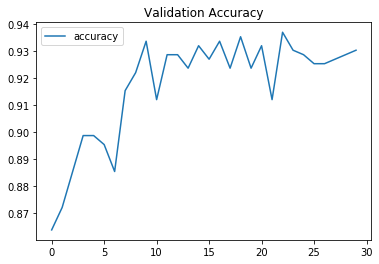

In [23]:
view_validation_accuracy('vgg11_bn')

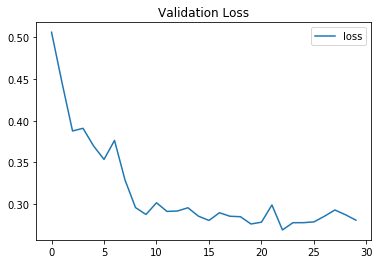

In [24]:
view_validation_loss('vgg11_bn')

In [25]:
model_ft = models.squeezenet1_1(pretrained=True)
num_ftrs = model_ft.classifier[1].in_channels
model_ft.classifier[1] = nn.Conv2d(512, len(class_names), kernel_size=(1, 1), stride=(1, 1))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
losses['squeezenet1_1'], accuracies['squeezenet1_1'], \
best_accuracy['squeezenet1_1'], time_expired['squeezenet1_1'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 2.5350 Acc: 0.2677
val Loss: 2.0581 Acc: 0.4053

Epoch 2/30
----------
train Loss: 1.9018 Acc: 0.4527
val Loss: 1.7596 Acc: 0.4601

Epoch 3/30
----------
train Loss: 1.5441 Acc: 0.5627
val Loss: 1.4454 Acc: 0.5598

Epoch 4/30
----------
train Loss: 1.3471 Acc: 0.6064
val Loss: 1.2644 Acc: 0.5980

Epoch 5/30
----------
train Loss: 1.2131 Acc: 0.6367
val Loss: 0.9597 Acc: 0.7259

Epoch 6/30
----------
train Loss: 1.1373 Acc: 0.6660
val Loss: 0.8231 Acc: 0.7674

Epoch 7/30
----------
train Loss: 1.0798 Acc: 0.6917
val Loss: 0.7813 Acc: 0.7575

Epoch 8/30
----------
train Loss: 0.6922 Acc: 0.8022
val Loss: 0.5441 Acc: 0.8405

Epoch 9/30
----------
train Loss: 0.5882 Acc: 0.8273
val Loss: 0.4836 Acc: 0.8472

Epoch 10/30
----------
train Loss: 0.5601 Acc: 0.8304
val Loss: 0.4838 Acc: 0.8588

Epoch 11/30
----------
train Loss: 0.5180 Acc: 0.8469
val Loss: 0.4775 Acc: 0.8588

Epoch 12/30
----------
train Loss: 0.5116 Acc: 0.8417
val Loss: 0.4946 Acc: 0.8505

E

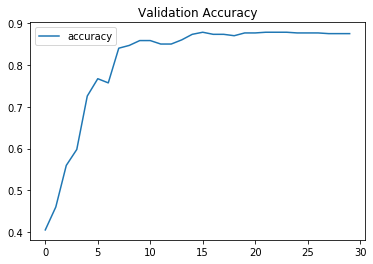

In [27]:
view_validation_accuracy('squeezenet1_1')

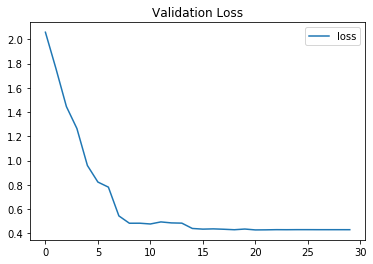

In [28]:
view_validation_loss('squeezenet1_1')

In [29]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
losses['densenet121'], accuracies['densenet121'], \
best_accuracy['densenet121'], time_expired['densenet121'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.7165 Acc: 0.5067
val Loss: 0.4420 Acc: 0.8738

Epoch 2/30
----------
train Loss: 1.1457 Acc: 0.6799
val Loss: 0.5911 Acc: 0.8422

Epoch 3/30
----------
train Loss: 1.0488 Acc: 0.6948
val Loss: 0.4632 Acc: 0.8804

Epoch 4/30
----------
train Loss: 0.9526 Acc: 0.7354
val Loss: 0.4321 Acc: 0.9020

Epoch 5/30
----------
train Loss: 0.9472 Acc: 0.7384
val Loss: 0.5097 Acc: 0.8804

Epoch 6/30
----------
train Loss: 0.9306 Acc: 0.7364
val Loss: 0.5029 Acc: 0.8904

Epoch 7/30
----------
train Loss: 0.8826 Acc: 0.7503
val Loss: 0.4263 Acc: 0.9086

Epoch 8/30
----------
train Loss: 0.6372 Acc: 0.8237
val Loss: 0.3776 Acc: 0.9269

Epoch 9/30
----------
train Loss: 0.5572 Acc: 0.8356
val Loss: 0.3567 Acc: 0.9336

Epoch 10/30
----------
train Loss: 0.5199 Acc: 0.8607
val Loss: 0.3514 Acc: 0.9319

Epoch 11/30
----------
train Loss: 0.5412 Acc: 0.8530
val Loss: 0.3488 Acc: 0.9336

Epoch 12/30
----------
train Loss: 0.4836 Acc: 0.8762
val Loss: 0.3233 Acc: 0.9352

E

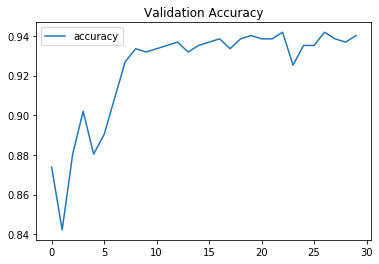

In [31]:
view_validation_accuracy('densenet121')

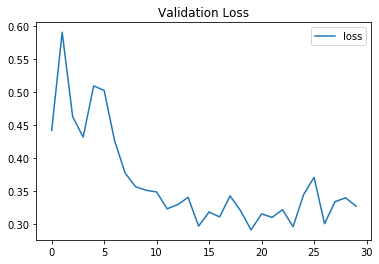

In [32]:
view_validation_loss('densenet121')

In [36]:
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
losses['googlenet'], accuracies['googlenet'], \
best_accuracy['googlenet'], time_expired['googlenet'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 2.0970 Acc: 0.4157
val Loss: 0.6407 Acc: 0.8522

Epoch 2/30
----------
train Loss: 1.2029 Acc: 0.6835
val Loss: 0.3364 Acc: 0.9037

Epoch 3/30
----------
train Loss: 0.9876 Acc: 0.7338
val Loss: 0.2664 Acc: 0.9252

Epoch 4/30
----------
train Loss: 0.8835 Acc: 0.7600
val Loss: 0.2493 Acc: 0.9302

Epoch 5/30
----------
train Loss: 0.8254 Acc: 0.7734
val Loss: 0.3092 Acc: 0.9136

Epoch 6/30
----------
train Loss: 0.7621 Acc: 0.7775
val Loss: 0.2537 Acc: 0.9203

Epoch 7/30
----------
train Loss: 0.7588 Acc: 0.7924
val Loss: 0.2372 Acc: 0.9435

Epoch 8/30
----------
train Loss: 0.6141 Acc: 0.8309
val Loss: 0.2345 Acc: 0.9435

Epoch 9/30
----------
train Loss: 0.6227 Acc: 0.8284
val Loss: 0.2075 Acc: 0.9468

Epoch 10/30
----------
train Loss: 0.5764 Acc: 0.8489
val Loss: 0.2211 Acc: 0.9468

Epoch 11/30
----------
train Loss: 0.5634 Acc: 0.8551
val Loss: 0.2107 Acc: 0.9485

Epoch 12/30
----------
train Loss: 0.5175 Acc: 0.8613
val Loss: 0.2246 Acc: 0.9485

E

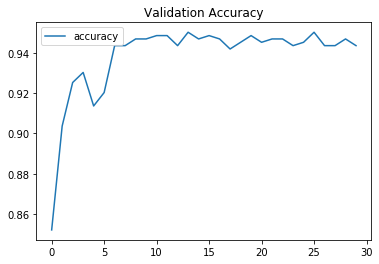

In [38]:
view_validation_accuracy('googlenet')

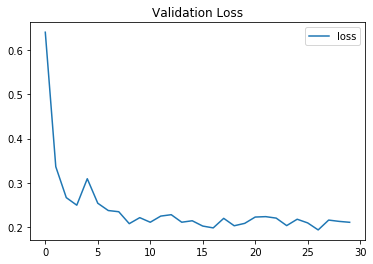

In [39]:
view_validation_loss('googlenet')

In [40]:
model_ft = models.shufflenet_v2_x0_5(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [41]:
losses['shufflenet_v2_x0_5'], accuracies['shufflenet_v2_x0_5'], \
best_accuracy['shufflenet_v2_x0_5'], time_expired['shufflenet_v2_x0_5'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 2.9657 Acc: 0.1131
val Loss: 2.9635 Acc: 0.0781

Epoch 2/30
----------
train Loss: 2.9184 Acc: 0.1187
val Loss: 2.9431 Acc: 0.0781

Epoch 3/30
----------
train Loss: 2.8894 Acc: 0.1187
val Loss: 2.9252 Acc: 0.0781

Epoch 4/30
----------
train Loss: 2.8656 Acc: 0.1187
val Loss: 2.9011 Acc: 0.0914

Epoch 5/30
----------
train Loss: 2.8405 Acc: 0.1280
val Loss: 2.8578 Acc: 0.1279

Epoch 6/30
----------
train Loss: 2.8137 Acc: 0.1475
val Loss: 2.8120 Acc: 0.1346

Epoch 7/30
----------
train Loss: 2.7773 Acc: 0.1650
val Loss: 2.7403 Acc: 0.1661

Epoch 8/30
----------
train Loss: 2.7416 Acc: 0.1819
val Loss: 2.7208 Acc: 0.1545

Epoch 9/30
----------
train Loss: 2.7354 Acc: 0.1876
val Loss: 2.7363 Acc: 0.1728

Epoch 10/30
----------
train Loss: 2.7325 Acc: 0.1963
val Loss: 2.7149 Acc: 0.1678

Epoch 11/30
----------
train Loss: 2.7195 Acc: 0.1973
val Loss: 2.7252 Acc: 0.1611

Epoch 12/30
----------
train Loss: 2.7200 Acc: 0.1917
val Loss: 2.6985 Acc: 0.1711

E

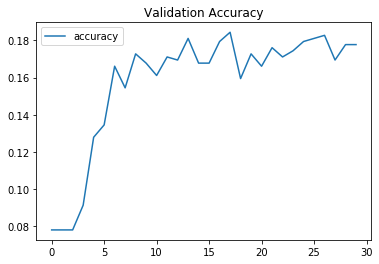

In [42]:
view_validation_accuracy('shufflenet_v2_x0_5')

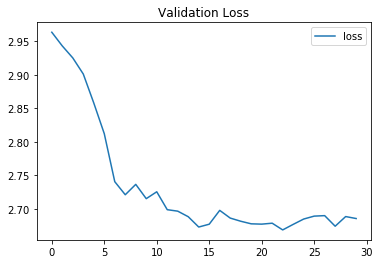

In [43]:
view_validation_loss('shufflenet_v2_x0_5')

In [44]:
model_ft = models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [45]:
losses['mobilenet_v2'], accuracies['mobilenet_v2'], \
best_accuracy['mobilenet_v2'], time_expired['mobilenet_v2'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.8604 Acc: 0.4527
val Loss: 0.7940 Acc: 0.7475

Epoch 2/30
----------
train Loss: 1.4343 Acc: 0.5910
val Loss: 0.7072 Acc: 0.7857

Epoch 3/30
----------
train Loss: 1.2994 Acc: 0.6305
val Loss: 0.6339 Acc: 0.8056

Epoch 4/30
----------
train Loss: 1.2818 Acc: 0.6367
val Loss: 0.6532 Acc: 0.8123

Epoch 5/30
----------
train Loss: 1.1380 Acc: 0.6778
val Loss: 0.6367 Acc: 0.8439

Epoch 6/30
----------
train Loss: 1.1901 Acc: 0.6660
val Loss: 0.5682 Acc: 0.8555

Epoch 7/30
----------
train Loss: 1.1226 Acc: 0.6819
val Loss: 0.5987 Acc: 0.8522

Epoch 8/30
----------
train Loss: 0.7351 Acc: 0.7914
val Loss: 0.4291 Acc: 0.9003

Epoch 9/30
----------
train Loss: 0.7639 Acc: 0.7831
val Loss: 0.4092 Acc: 0.8970

Epoch 10/30
----------
train Loss: 0.6848 Acc: 0.8078
val Loss: 0.3873 Acc: 0.9070

Epoch 11/30
----------
train Loss: 0.6484 Acc: 0.8196
val Loss: 0.3778 Acc: 0.9120

Epoch 12/30
----------
train Loss: 0.6263 Acc: 0.8304
val Loss: 0.3619 Acc: 0.9186

E

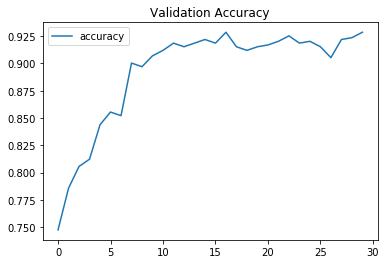

In [46]:
view_validation_accuracy('mobilenet_v2')

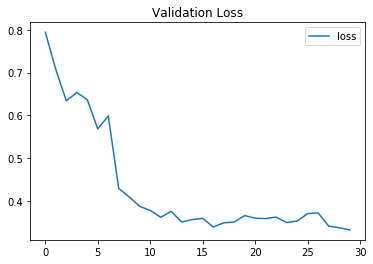

In [47]:
view_validation_loss('mobilenet_v2')

In [48]:
model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
losses['resnext50_32x4d'], accuracies['resnext50_32x4d'], \
best_accuracy['resnext50_32x4d'], time_expired['resnext50_32x4d'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.5611 Acc: 0.5565
val Loss: 0.3985 Acc: 0.8937

Epoch 2/30
----------
train Loss: 1.0768 Acc: 0.7009
val Loss: 0.6656 Acc: 0.8621

Epoch 3/30
----------
train Loss: 0.9722 Acc: 0.7282
val Loss: 0.4406 Acc: 0.8953

Epoch 4/30
----------
train Loss: 0.9208 Acc: 0.7441
val Loss: 0.5882 Acc: 0.8754

Epoch 5/30
----------
train Loss: 0.8413 Acc: 0.7734
val Loss: 0.5385 Acc: 0.8920

Epoch 6/30
----------
train Loss: 0.7812 Acc: 0.7939
val Loss: 0.4769 Acc: 0.8837

Epoch 7/30
----------
train Loss: 0.8477 Acc: 0.7595
val Loss: 0.6106 Acc: 0.8605

Epoch 8/30
----------
train Loss: 0.6443 Acc: 0.8196
val Loss: 0.3920 Acc: 0.9169

Epoch 9/30
----------
train Loss: 0.5646 Acc: 0.8510
val Loss: 0.3763 Acc: 0.9203

Epoch 10/30
----------
train Loss: 0.4556 Acc: 0.8803
val Loss: 0.3502 Acc: 0.9369

Epoch 11/30
----------
train Loss: 0.4220 Acc: 0.8905
val Loss: 0.3080 Acc: 0.9336

Epoch 12/30
----------
train Loss: 0.4104 Acc: 0.8869
val Loss: 0.3026 Acc: 0.9352

E

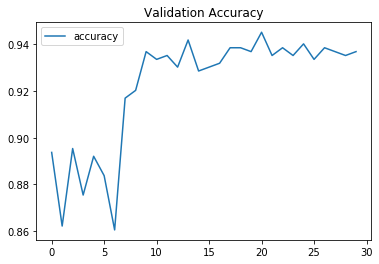

In [50]:
view_validation_accuracy('resnext50_32x4d')

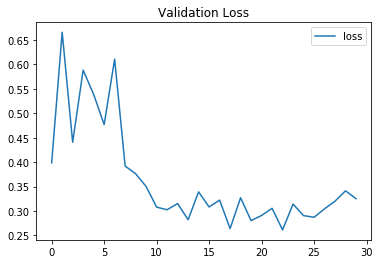

In [51]:
view_validation_loss('resnext50_32x4d')

In [52]:
model_ft = models.wide_resnet50_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to C:\Users\gloas/.cache\torch\checkpoints\wide_resnet50_2-95faca4d.pth


In [53]:
losses['wide_resnet50_2'], accuracies['wide_resnet50_2'], \
best_accuracy['wide_resnet50_2'], time_expired['wide_resnet50_2'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 1.7664 Acc: 0.5046
val Loss: 0.4037 Acc: 0.8854

Epoch 2/30
----------
train Loss: 1.0957 Acc: 0.6963
val Loss: 0.5036 Acc: 0.8787

Epoch 3/30
----------
train Loss: 1.0345 Acc: 0.7076
val Loss: 0.6895 Acc: 0.8920

Epoch 4/30
----------
train Loss: 1.0200 Acc: 0.7117
val Loss: 0.5091 Acc: 0.8870

Epoch 5/30
----------
train Loss: 0.8896 Acc: 0.7631
val Loss: 0.6812 Acc: 0.8555

Epoch 6/30
----------
train Loss: 0.8641 Acc: 0.7662
val Loss: 0.5888 Acc: 0.8754

Epoch 7/30
----------
train Loss: 0.8526 Acc: 0.7616
val Loss: 0.4998 Acc: 0.8837

Epoch 8/30
----------
train Loss: 0.6445 Acc: 0.8243
val Loss: 0.3685 Acc: 0.9302

Epoch 9/30
----------
train Loss: 0.5388 Acc: 0.8551
val Loss: 0.3596 Acc: 0.9369

Epoch 10/30
----------
train Loss: 0.5133 Acc: 0.8587
val Loss: 0.3055 Acc: 0.9419

Epoch 11/30
----------
train Loss: 0.5058 Acc: 0.8577
val Loss: 0.3093 Acc: 0.9468

Epoch 12/30
----------
train Loss: 0.5265 Acc: 0.8607
val Loss: 0.3476 Acc: 0.9435

E

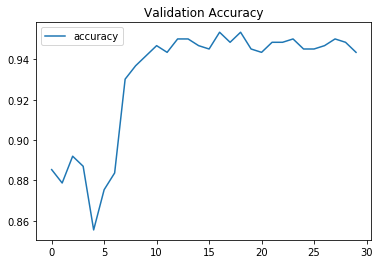

In [54]:
view_validation_accuracy('wide_resnet50_2')

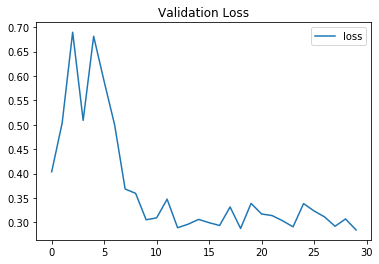

In [55]:
view_validation_loss('wide_resnet50_2')

In [57]:
model_ft = models.mnasnet0_5(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

del optimizer_ft
del exp_lr_scheduler

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to C:\Users\gloas/.cache\torch\checkpoints\mnasnet0.5_top1_67.823-3ffadce67e.pth


In [58]:
losses['mnasnet0_5'], accuracies['mnasnet0_5'], \
best_accuracy['mnasnet0_5'], time_expired['mnasnet0_5'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
train Loss: 2.9223 Acc: 0.1213
val Loss: 2.8509 Acc: 0.1429

Epoch 2/30
----------
train Loss: 2.8211 Acc: 0.1691
val Loss: 2.7432 Acc: 0.1645

Epoch 3/30
----------
train Loss: 2.7601 Acc: 0.2020
val Loss: 2.6443 Acc: 0.1844

Epoch 4/30
----------
train Loss: 2.6963 Acc: 0.2091
val Loss: 2.5467 Acc: 0.2110

Epoch 5/30
----------
train Loss: 2.6377 Acc: 0.2374
val Loss: 2.4495 Acc: 0.2326

Epoch 6/30
----------
train Loss: 2.5761 Acc: 0.2482
val Loss: 2.3537 Acc: 0.2924

Epoch 7/30
----------
train Loss: 2.5057 Acc: 0.2616
val Loss: 2.2547 Acc: 0.3522

Epoch 8/30
----------
train Loss: 2.4785 Acc: 0.2677
val Loss: 2.2529 Acc: 0.3538

Epoch 9/30
----------
train Loss: 2.4701 Acc: 0.2703
val Loss: 2.2507 Acc: 0.3571

Epoch 10/30
----------
train Loss: 2.4616 Acc: 0.2770
val Loss: 2.2484 Acc: 0.3621

Epoch 11/30
----------
train Loss: 2.4653 Acc: 0.2749
val Loss: 2.2449 Acc: 0.3621

Epoch 12/30
----------
train Loss: 2.4517 Acc: 0.2790
val Loss: 2.2406 Acc: 0.3688

E

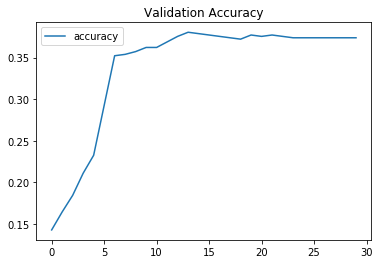

In [59]:
view_validation_accuracy('mnasnet0_5')

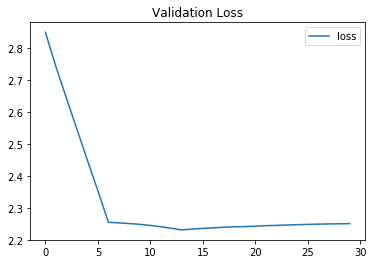

In [60]:
view_validation_loss('mnasnet0_5')

In [5]:
# Data augmentation and normalization just for training inception
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# include CalTech

data_dir = 'data/CalTech256'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes, class_names, sep='\n')

{'train': 1946, 'val': 602}
['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101']


In [7]:
model_ft = models.inception_v3(pretrained=True, aux_logits=False)

# for aux_logits=True
# num_ftrs_AuxLogits = model_ft.AuxLogits.fc.in_features
# model_ft.AuxLogits.fc = nn.Linear(768, len(class_names))

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(2048, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
losses['inception_v3'], accuracies['inception_v3'], \
best_accuracy['inception_v3'], time_expired['inception_v3'] = \
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 1/30
----------
3.0180282592773438
1
3.0180282592773438
2.9576144218444824
1
5.975642681121826
3.129516839981079
1
9.105159521102905
2.835458993911743
1
11.940618515014648
3.0514819622039795
1
14.992100477218628
2.9347565174102783
1
17.926856994628906
3.627052068710327
1
21.553909063339233
3.0259323120117188
1
24.579841375350952
3.6783623695373535
1
28.258203744888306
3.68886661529541
1
31.947070360183716
3.750457763671875
1
35.69752812385559
3.472005605697632
1
39.16953372955322
2.715639352798462
1
41.885173082351685
3.528858184814453
1
45.41403126716614
2.4239001274108887
1
47.837931394577026
3.7377233505249023
1
51.57565474510193
3.916870594024658
1
55.49252533912659
2.512587785720825
1
58.00511312484741
3.9371566772460938
1
61.942269802093506
3.0922539234161377
1
65.03452372550964
3.758824110031128
1
68.79334783554077
3.795778751373291
1
72.58912658691406
3.453306198120117
1
76.04243278503418
1.902502179145813
1
77.94493496417999
3.4302921295166016
1
81.3752270936966
2.884793

2.7741730213165283
1
684.4943528175354
3.2916131019592285
1
687.7859659194946
3.5893425941467285
1
691.3753085136414
2.0248990058898926
1
693.4002075195312
4.450811862945557
1
697.8510193824768
2.239807605743408
1
700.0908269882202
3.7659406661987305
1
703.856767654419
3.489806652069092
1
707.346574306488
3.608497381210327
1
710.9550716876984
3.5959885120391846
1
714.5510601997375
3.0906405448913574
1
717.6417007446289
3.2035646438598633
1
720.8452653884888
3.1439754962921143
1
723.9892408847809
3.5500802993774414
1
727.5393211841583
1.8003203868865967
1
729.3396415710449
3.34116792678833
1
732.6808094978333
3.2882492542266846
1
735.9690587520599
3.185246229171753
1
739.1543049812317
2.7923223972320557
1
741.9466273784637
2.8306009769439697
1
744.7772283554077
3.381256580352783
1
748.1584849357605
2.9420361518859863
1
751.1005210876465
3.9967353343963623
1
755.0972564220428
2.9119911193847656
1
758.0092475414276
2.790565013885498
1
760.7998125553131
3.1378705501556396
1
763.93768310546

3.047168254852295
1
1317.3548048734665
4.0724968910217285
1
1321.4273017644882
3.2751684188842773
1
1324.7024701833725
2.8444595336914062
1
1327.546929717064
3.8580620288848877
1
1331.4049917459488
2.028670310974121
1
1333.433662056923
2.384434461593628
1
1335.8180965185165
3.654849052429199
1
1339.4729455709457
2.954612970352173
1
1342.427558541298
1.9365226030349731
1
1344.3640811443329
4.065418720245361
1
1348.4294998645782
3.7685134410858154
1
1352.198013305664
2.947183609008789
1
1355.1451969146729
3.0317294597625732
1
1358.1769263744354
2.6795055866241455
1
1360.8564319610596
3.014430284500122
1
1363.8708622455597
2.7174265384674072
1
1366.588288784027
2.62186336517334
1
1369.2101521492004
3.117377996444702
1
1372.3275301456451
3.729173421859741
1
1376.0567035675049
2.6074626445770264
1
1378.664166212082
2.8516368865966797
1
1381.5158030986786
2.16064715385437
1
1383.676450252533
3.690903425216675
1
1387.3673536777496
3.09295392036438
1
1390.460307598114
2.943291664123535
1
1393.

3.246277093887329
1
1934.5403770208359
3.220848560333252
1
1937.7612255811691
1.5075112581253052
1
1939.2687368392944
1.5719009637832642
1
1940.8406378030777
3.267836570739746
1
1944.1084743738174
3.1557092666625977
1
1947.26418364048
3.1269781589508057
1
1950.3911617994308
1.4416369199752808
1
1951.8327987194061
1.379317283630371
1
1953.2121160030365
2.9192402362823486
1
1956.1313562393188
3.521958589553833
1
1959.6533148288727
3.0333001613616943
1
1962.6866149902344
2.8022687435150146
1
1965.4888837337494
2.8608713150024414
1
1968.3497550487518
2.8966472148895264
1
1971.2464022636414
0.8142263889312744
1
1972.0606286525726
3.6649587154388428
1
1975.7255873680115
3.455955743789673
1
1979.1815431118011
2.618393659591675
1
1981.7999367713928
2.68178653717041
1
1984.4817233085632
3.1592483520507812
1
1987.640971660614
3.170840263366699
1
1990.8118119239807
2.536536693572998
1
1993.3483486175537
1.6648322343826294
1
1995.0131808519363
3.343888282775879
1
1998.3570691347122
2.4328525066375

In [ ]:
view_validation_accuracy('inception_v3')

In [ ]:
view_validation_loss('inception_v3')

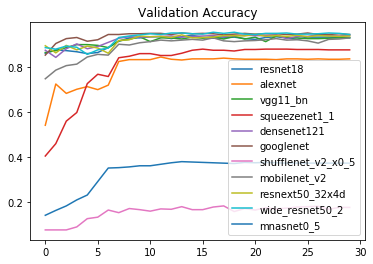

In [61]:
view_accuracy_all()

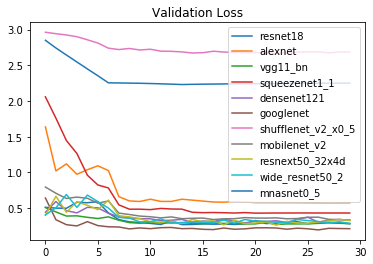

In [62]:
view_loss_all()

In [124]:
import pandas as pd

# for top-k errors, best_accuracy and time_expired
models_dict = {'name': ['resnet18', 'alexnet', 'vgg11_bn',
                    'squeezenet1_1', 'densenet121',
                    'googlenet', 'shufflenet_v2_x0_5', 'mobilenet_v2',
                    'resnext50_32x4d', 'wide_resnet50_2', 'mnasnet0_5']}

models_df = pd.DataFrame(models_dict)

models_df['best_accuracy'] = best_accuracy['resnet18']
counter = 0
for name in models_dict['name']:
    models_df['best_accuracy'][counter] = best_accuracy[name]
    counter += 1
    pass

models_df['time_expired'] = time_expired['resnet18']
counter = 0
for name in models_dict['name']:
    models_df['time_expired'][counter] = time_expired[name] / 3600
    counter += 1
    pass

print(models_df)

models_df.to_csv('models_statistics')

new_losses = {}
new_accuracies = {}
for i in models_dict['name']:
    new_losses[i] = [losses[i][0] / 3.]
    for j in range(1, len(losses[i])):
        new_losses[i].append(losses[i][j] / 3.)
        pass
    for j in range(len(accuracies[i])):
        accuracies[i] = accuracies[i][j]
        pass
    pass

pd.DataFrame(new_losses).to_csv('models_losses_v3.csv')
pd.DataFrame(accuracies).to_csv('models_accuracies_v3.csv')

                  name  best_accuracy  time_expired
0             resnet18       0.940199      0.482758
1              alexnet       0.843854      0.462189
2             vgg11_bn       0.936877      1.213869
3        squeezenet1_1       0.878738      0.237248
4          densenet121       0.941860      1.258175
5            googlenet       0.950166      0.794686
6   shufflenet_v2_x0_5       0.184385      0.526292
7         mobilenet_v2       0.928571      0.477950
8      resnext50_32x4d       0.945183      1.081688
9      wide_resnet50_2       0.953488      2.195467
10          mnasnet0_5       0.380399      0.638248


C:\Users\gloas\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gloas\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: If using all scalar values, you must pass an index

In [13]:
import pandas as pd

new_losses = {}

new_losses['resnet34'] = [losses['resnet34'][0] / 3.]
for j in range(1, len(losses['resnet34'])):
    new_losses['resnet34'].append(losses['resnet34'][j] / 3.)
    pass

pd.DataFrame(new_losses).to_csv('resnet34_losses.csv')
pd.DataFrame(accuracies).to_csv('resnet34_accuracies.csv')